# Hyperparameter Tuning

* Metode Optimisasi yang digunakan adalah Bayesian dengan tools Optuna

Adapun hyperparameter yang dioptimisasi yaitu:
* Learning Rate: Rentang 0.01 - 0.05
  - Alasan: Nilai ini cukup umum digunakan untuk algoritma berbasis optimasi seperti Adam. Rentang ini memungkinkan model belajar dengan kecepatan yang tidak terlalu lambat (yang bisa menyebabkan underfitting) dan tidak terlalu cepat (yang bisa menyebabkan overshooting atau ketidakstabilan selama pelatihan).
*  Dropout Rate: Rentang 0.1 - 0.5
  - Alasan: Rentang 0.1 hingga 0.5 adalah rekomendasi umum dalam literatur deep learning. Rentang 0.1 hingga 0.5 cukup untuk memastikan bahwa kapasitas model tidak berlebihan (overfitting) tetapi tetap cukup fleksibel untuk menyerap informasi penting
* Jumlah Unit dalam GRU Layer: Rentang 16−32
  - Alasan: Rentang ini cukup kecil untuk menjaga efisiensi komputasi, namun cukup besar untuk menangkap pola kompleks dalam data. Secara sederhana, mempertahankan model yang cukup ringan untuk pelatihan cepat.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [2]:
# Load Data
df = pd.read_csv('Emotion_Dataset.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
# Duplicates
df.duplicated().sum()

3

In [4]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)
print(f'The Shape Of Data After Dropping Duplicates Is : {df.shape}')

The Shape Of Data After Dropping Duplicates Is : (21456, 2)


<ipython-input-5-4d7f46912228>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


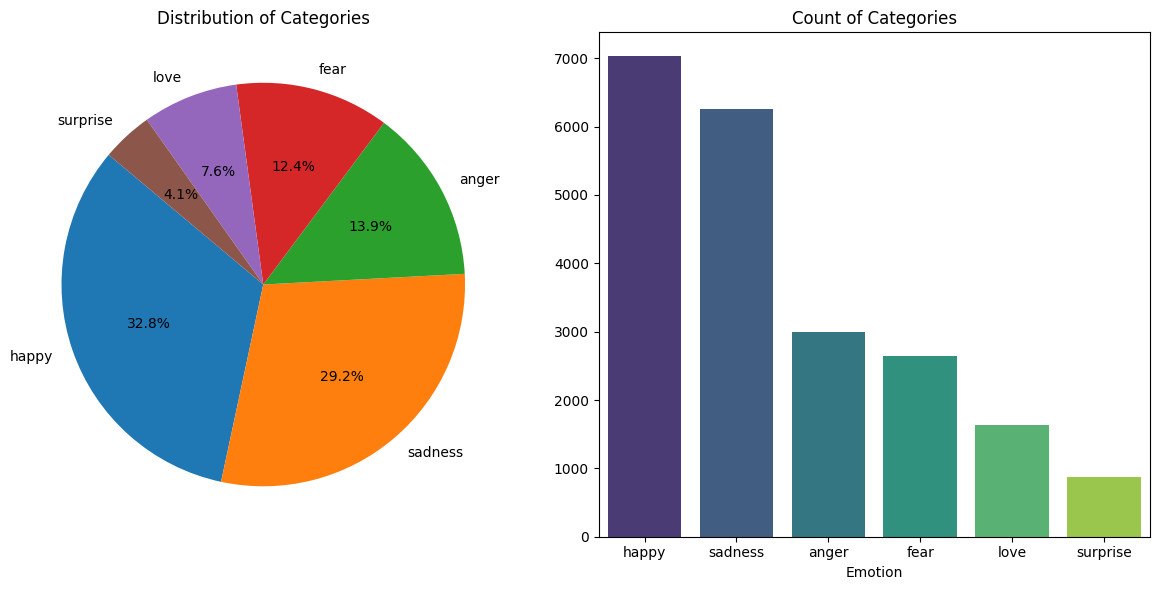

In [5]:
# Value Count Of Label
count = df['Emotion'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

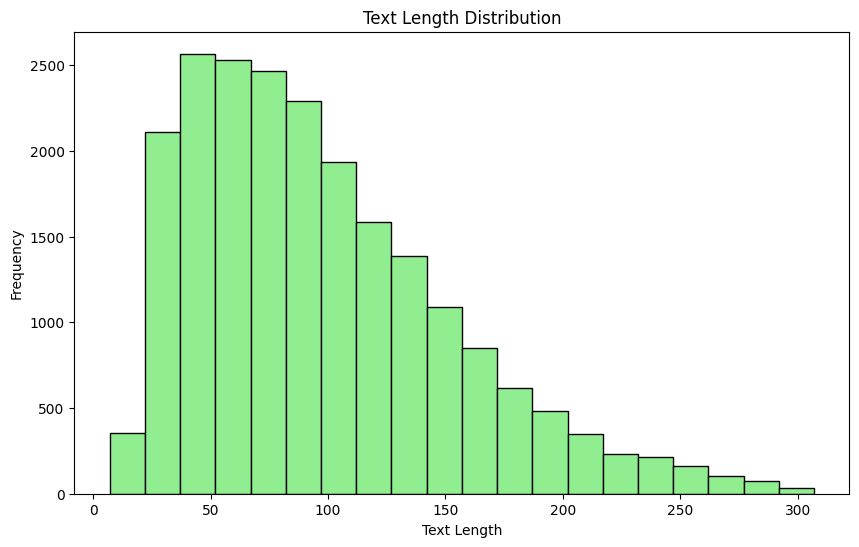

,Text_Length
count,21456.000000
mean,96.714346
std,55.386278
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,307.000000


In [6]:
df['Text_Length'] = df['Text'].apply(len)

plt.figure(figsize=(10, 6))
df['Text_Length'].plot(kind='hist', bins=20, color='lightgreen', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Prepare summary statistics of text lengths
length_stats = df['Text_Length'].describe()
length_stats

In [7]:
df.head()

,Text,Emotion,Text_Length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [8]:
df = df.drop(['Text_Length'], axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
# Perform label encoding on the Emotion column
label_encoder = LabelEncoder()
df['Emotion_Label'] = label_encoder.fit_transform(df['Emotion'])

# Display the mapping of emotions to encoded values and the processed dataset
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

label_mapping

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [10]:
# Step 1: Remove special characters and punctuation
df['Cleaned_Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Emotion  Emotion_Label  \
0                            i didnt feel humiliated  sadness              4   
1  i can go from feeling so hopeless to so damned...  sadness              4   
2   im grabbing a minute to post i feel greedy wrong    anger              0   
3  i am ever feeling nostalgic about the fireplac...     love              3   
4                               i am feeling grouchy    anger              0   

                                        Cleaned_Text  
0                            i didnt feel humiliated  
1  i can go from feeling so hopeless to so damned...  
2   im grabbing a minute to post i feel greedy wrong  
3  i am ever feeling nostalgic about the fireplac...  
4                               i am feeling grouchy  


In [11]:
# Step 2: Remove extra whitespaces
df['Cleaned_Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Emotion  Emotion_Label  \
0                            i didnt feel humiliated  sadness              4   
1  i can go from feeling so hopeless to so damned...  sadness              4   
2   im grabbing a minute to post i feel greedy wrong    anger              0   
3  i am ever feeling nostalgic about the fireplac...     love              3   
4                               i am feeling grouchy    anger              0   

                                        Cleaned_Text  
0                            i didnt feel humiliated  
1  i can go from feeling so hopeless to so damned...  
2   im grabbing a minute to post i feel greedy wrong  
3  i am ever feeling nostalgic about the fireplac...  
4                               i am feeling grouchy  


In [12]:
# Step 3: Remove numeric values
df['Cleaned_Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

# Head
df.head()

,Text,Emotion,Emotion_Label,Cleaned_Text
0,i didnt feel humiliated,sadness,4,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,0,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,0,i am feeling grouchy


In [13]:
# Step 4: Lowercasing
df['Cleaned_Text'] = df['Text'].str.lower()

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Emotion  Emotion_Label  \
0                            i didnt feel humiliated  sadness              4   
1  i can go from feeling so hopeless to so damned...  sadness              4   
2   im grabbing a minute to post i feel greedy wrong    anger              0   
3  i am ever feeling nostalgic about the fireplac...     love              3   
4                               i am feeling grouchy    anger              0   

                                        Cleaned_Text  
0                            i didnt feel humiliated  
1  i can go from feeling so hopeless to so damned...  
2   im grabbing a minute to post i feel greedy wrong  
3  i am ever feeling nostalgic about the fireplac...  
4                               i am feeling grouchy  


In [14]:
# Step : 5 Remove non-alphanumeric characters
df['Cleaned_Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Emotion,Emotion_Label,Cleaned_Text
0,i didnt feel humiliated,sadness,4,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,0,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,0,i am feeling grouchy


In [15]:
# Import Basis Needed Libaries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# Step 6: Remove stop words
from nltk.corpus import stopwords

# Get the default English stop words as a set
stop_words = set(stopwords.words('english'))

# Define custom stop words as a set
custom_stopwords = {"i", "im", "am","make", "didnt", "ive", "dont", "still",
                    "one", "toward", "would", "thing", "way", "could", "even", "much", "always",
                    "also", "around", "something", "dont", "cant", "ever",
                    "get", "go", "know", "time", "make", "say", "people", "day", "life", "bit", "look", "well"}

# Update the stop words set with custom stop words
stop_words.update(custom_stopwords)

# Apply the stop word removal to the 'Cleaned_Text' column
df["Cleaned_Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Emotion,Emotion_Label,Cleaned_Text
0,i didnt feel humiliated,sadness,4,feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,feeling hopeless damned hopeful someone cares ...
2,im grabbing a minute to post i feel greedy wrong,anger,0,grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,feeling nostalgic fireplace property
4,i am feeling grouchy,anger,0,feeling grouchy


In [17]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet') # Download resource WordNet jika belum ada
nltk.download('averaged_perceptron_tagger') # Download resource POS tagger

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [18]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')
# Download the 'averaged_perceptron_tagger_eng' resource specifically
nltk.download('averaged_perceptron_tagger_eng') # This line downloads the missing data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [20]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    # Tokenisasi teks menjadi kata-kata
    tokens = nltk.word_tokenize(text)

    # Lematisasi setiap kata dengan POS tag yang sesuai
    lemmas = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)) for word in tokens]

    # Gabungkan kembali kata-kata menjadi teks
    return ' '.join(lemmas)


df['Cleaned_Text'] = df['Cleaned_Text'].apply(lemmatize_text)

In [21]:
df.head()

,Text,Emotion,Emotion_Label,Cleaned_Text
0,i didnt feel humiliated,sadness,4,feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,4,feel hopeless damn hopeful someone care awake
2,im grabbing a minute to post i feel greedy wrong,anger,0,grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,feel nostalgic fireplace property
4,i am feeling grouchy,anger,0,feel grouchy


In [22]:
X = df['Cleaned_Text']
y = df['Emotion_Label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17164,)
X_test shape: (4292,)
y_train shape: (17164,)
y_test shape: (4292,)


In [23]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [24]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 29


In [25]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[  1   2 105 ...   0   0   0]
 [184   1 144 ...   0   0   0]
 [854   1 627 ...   0   0   0]
 ...
 [  1 742   0 ...   0   0   0]
 [ 15   1   5 ...   0   0   0]
 [  1 613 429 ...   0   0   0]]

X_test_padded:
[[  11 1583 1517 ...    0    0    0]
 [   9   18   13 ...    0    0    0]
 [   1  304    0 ...    0    0    0]
 ...
 [  11    1   47 ...    0    0    0]
 [  50   53    1 ...    0    0    0]
 [  11    1  854 ...    0    0    0]]


In [26]:
##Embedding Input Size / Vocabulary Size
# Calculate maximum index from both training and testing data
max_index_train = np.max(X_train_padded)
max_index_test = np.max(X_test_padded)
input_Size = max(max_index_train, max_index_test) + 1  # Add 1 for 0-based indexing

input_Size

5000

In [27]:
# Define the model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=input_Size, output_dim=50, input_length=maxlen))

# Dropout
model.add(Dropout(0.5))

# Add Bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#Batch Normalization
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.2960 - loss: 1.6915 - val_accuracy: 0.4737 - val_loss: 1.7658
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4736 - loss: 1.4396 - val_accuracy: 0.5575 - val_loss: 1.7316
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6596 - loss: 1.0049 - val_accuracy: 0.7484 - val_loss: 1.6400
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8052 - loss: 0.5947 - val_accuracy: 0.8211 - val_loss: 1.5249
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8712 - loss: 0.3929 - val_accuracy: 0.8486 - val_loss: 1.4232
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8978 - loss: 0.2982 - val_accuracy: 0.8602 - val_loss: 1.3364
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9146 - loss: 0.2469 - val_accuracy: 0.8684 - val_loss: 1.2683
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9261 - loss: 0.2040 - val_accuracy: 0.8693 - val_loss:

In [29]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred_classes)

# Print the classification report
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print(report)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Accuracy: 0.8653308480894688
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       593
           1       0.92      0.71      0.80       529
           2       0.90      0.91      0.90      1416
           3       0.80      0.72      0.76       312
           4       0.92      0.90      0.91      1273
           5       0.65      0.83      0.73       169

    accuracy                           0.87      4292
   macro avg       0.83      0.83      0.82      4292
weighted avg       0.87      0.87      0.87      4292



In [30]:
y_pred = model.predict(X_test_padded)  # Prediksi probabilitas
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi ke label kelas

# Label sebenarnya (jika y_test adalah one-hot, konversi ke kelas)
y_test_actual = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Membuat laporan klasifikasi
target_names = ["Happy", "Sadness", "Anger", "Fear", "Love", "Surprise"]  # Ganti dengan label kelas Anda
report = classification_report(y_test_actual, y_pred_classes, target_names=target_names)
accuracy = accuracy_score(y_test_actual, y_pred_classes)
print('accuracy: ', accuracy)
print(report)

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step
accuracy:  0.8653308480894688
              precision    recall  f1-score   support

       Happy       0.76      0.92      0.83       593
     Sadness       0.92      0.71      0.80       529
       Anger       0.90      0.91      0.90      1416
        Fear       0.80      0.72      0.76       312
        Love       0.92      0.90      0.91      1273
    Surprise       0.65      0.83      0.73       169

    accuracy                           0.87      4292
   macro avg       0.83      0.83      0.82      4292
weighted avg       0.87      0.87      0.87      4292



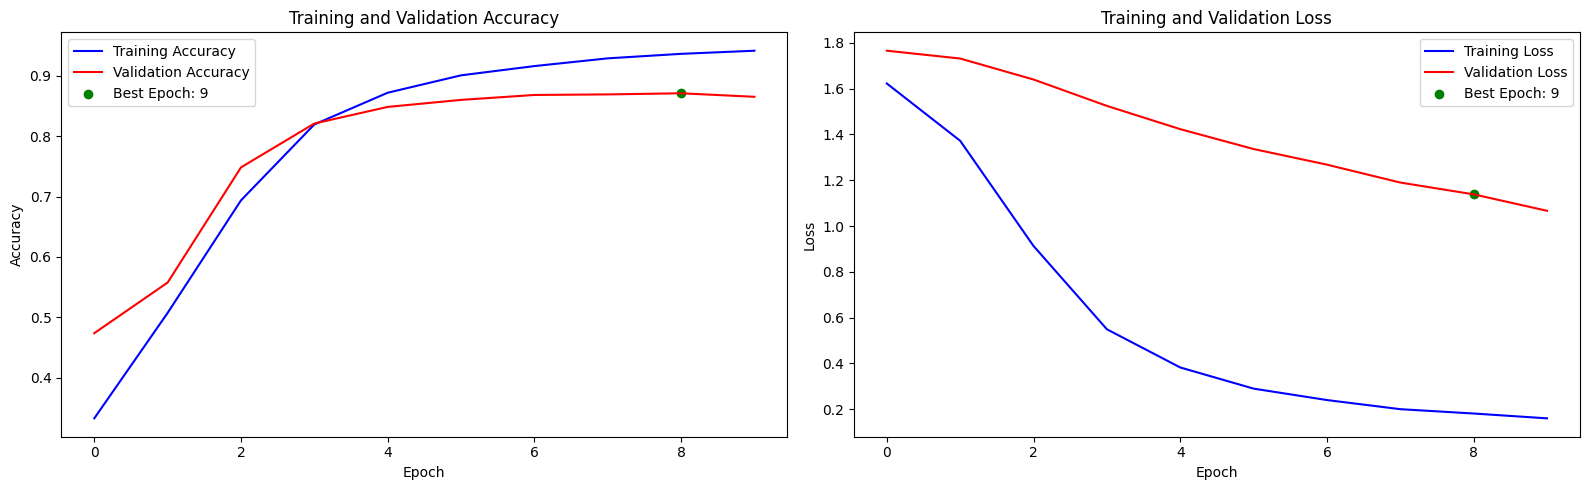

In [31]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green',
               label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',
               label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [32]:
# Evaluate Test Data
model.evaluate(X_test_padded, y_test)

135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8687 - loss: 1.0612


[1.0668606758117676, 0.8653308749198914]

135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


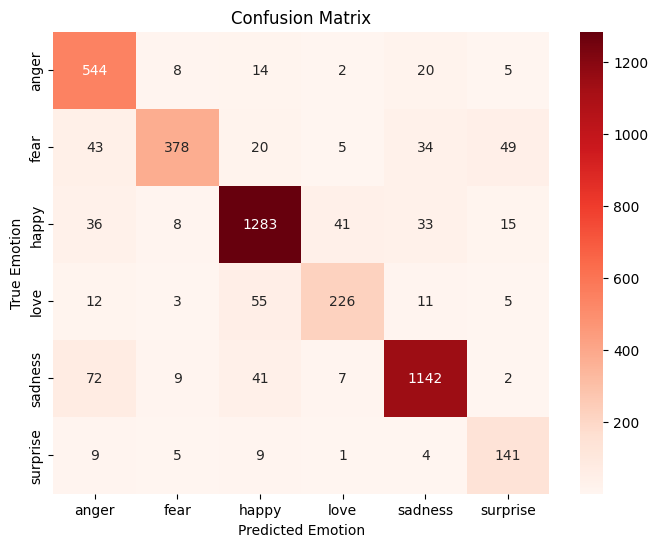

In [33]:

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

# Get the original emotion labels from the LabelEncoder
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

cm = confusion_matrix(y_test_original, y_pred_original)

# Create a list of unique emotion labels
emotion_labels = list(label_encoder.classes_)

# Plot the confusion matrix with emotion labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()

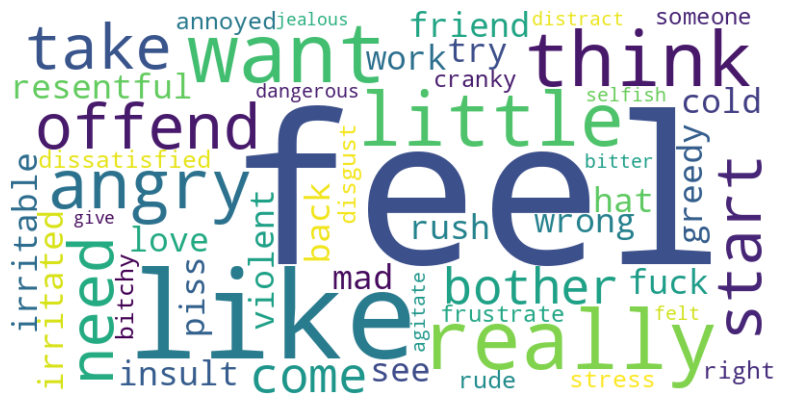

In [34]:
#word cloud for anger emotion
happy_text = df[df['Emotion'] == 'anger']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

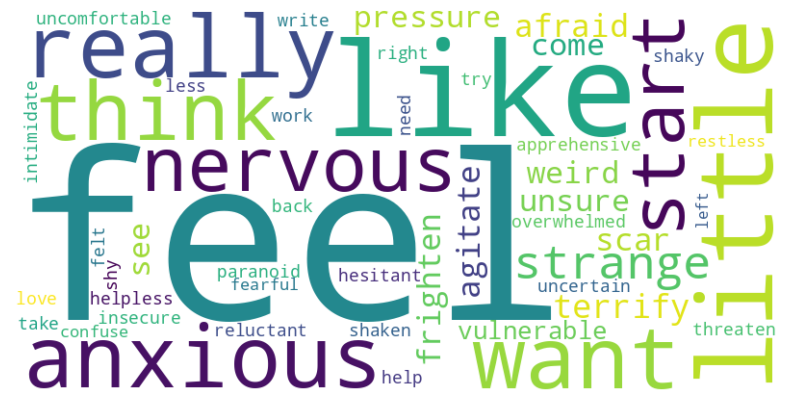

In [35]:
#word cloud for fear emotion
happy_text = df[df['Emotion'] == 'fear']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

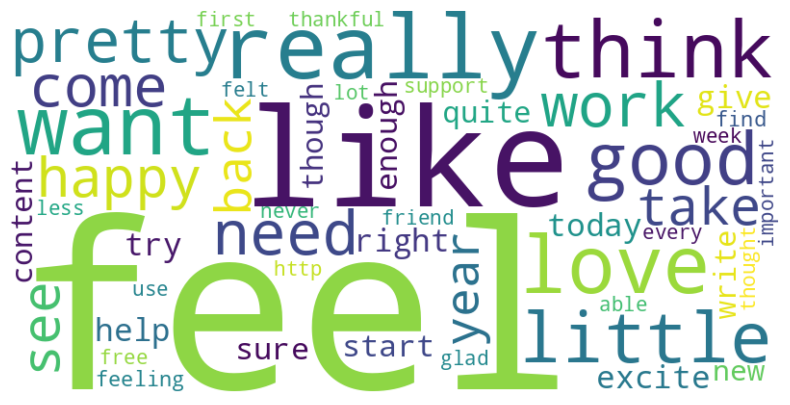

In [36]:
#word cloud for happy emotion
happy_text = df[df['Emotion'] == 'happy']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

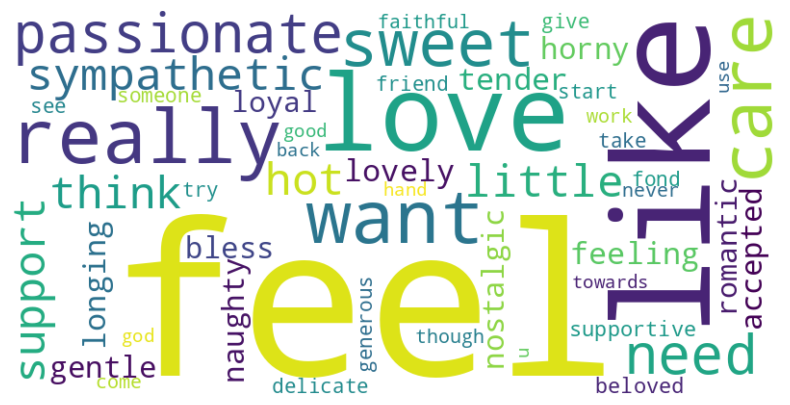

In [37]:
#word cloud for love emotion
happy_text = df[df['Emotion'] == 'love']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

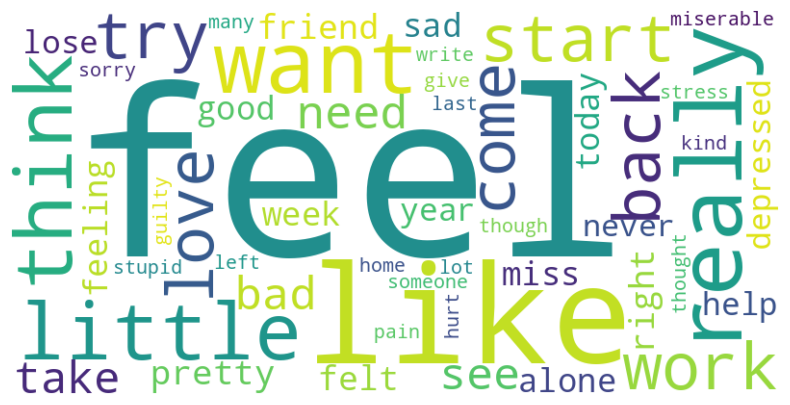

In [38]:
#word cloud for sadness emotion
happy_text = df[df['Emotion'] == 'sadness']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

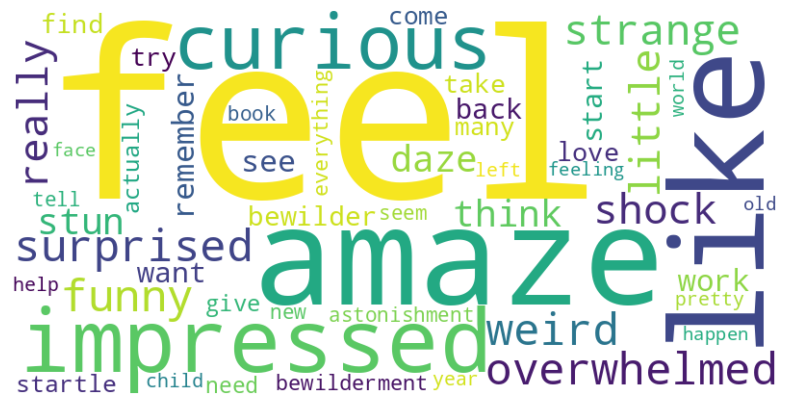

In [39]:
#word cloud for surprise emotion
happy_text = df[df['Emotion'] == 'surprise']['Cleaned_Text']
all_text = ' '.join(happy_text)

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words,
                      max_words=50, collocations=False,background_color='white').generate(all_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df.head()

,Text,Emotion,Emotion_Label,Cleaned_Text
0,i didnt feel humiliated,sadness,4,feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,4,feel hopeless damn hopeful someone care awake
2,im grabbing a minute to post i feel greedy wrong,anger,0,grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,feel nostalgic fireplace property
4,i am feeling grouchy,anger,0,feel grouchy


In [41]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [43]:
import optuna
import tensorflow as tf

def objective(trial):
    # Define the hyperparameters to be tuned
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.05)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    units = trial.suggest_int("units", 16, 32)

    # Create the model with the suggested hyperparameters
    model = Sequential()
    model.add(Embedding(input_dim=input_Size, output_dim=50, input_length=maxlen))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(GRU(units, return_sequences=True)))
    model.add(Bidirectional(GRU(units // 2, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Bidirectional(GRU(units // 2)))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_padded, y_train, epochs=10, batch_size=1500,
                        validation_data=(X_test_padded, y_test), verbose=0)

    # Get the validation accuracy from the last epoch
    validation_accuracy = history.history['val_accuracy'][-1]

    return validation_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20) # Adjust n_trials as needed

# Print the best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2024-12-01 01:28:48,497] A new study created in memory with name: no-name-0cbb789b-281c-4f6d-bae8-c94638243584
[I 2024-12-01 01:31:22,041] Trial 0 finished with value: 0.8655638694763184 and parameters: {'learning_rate': 0.046412087311544975, 'dropout_rate': 0.17847978854448332, 'units': 29}. Best is trial 0 with value: 0.8655638694763184.
[I 2024-12-01 01:33:14,026] Trial 1 finished with value: 0.8790773749351501 and parameters: {'learning_rate': 0.0151897324086687, 'dropout_rate': 0.13346964374740208, 'units': 22}. Best is trial 1 with value: 0.8790773749351501.
[I 2024-12-01 01:34:58,056] Trial 2 finished with value: 0.8946877717971802 and parameters: {'learning_rate': 0.02404751675811053, 'dropout_rate': 0.4338118362969773, 'units': 18}. Best is trial 2 with value: 0.8946877717971802.
[I 2024-12-01 01:36:57,742] Trial 3 finished with value: 0.8869990706443787 and parameters: {'learning_rate': 0.025879942437107152, 'dropout_rate': 0.31207921704708574, 'units': 18}. Best is trial 

Best hyperparameters: {'learning_rate': 0.02863445695392297, 'dropout_rate': 0.4663404852551372, 'units': 29}
Best validation accuracy: 0.9137930870056152


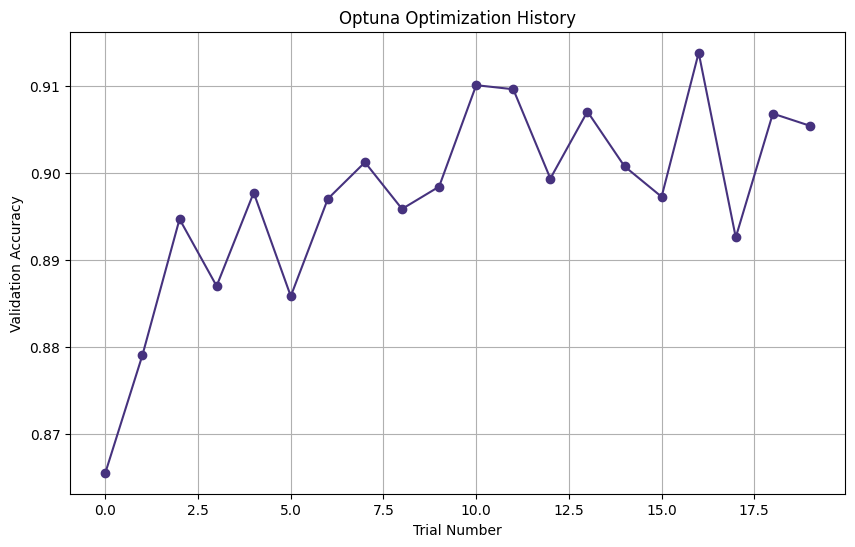

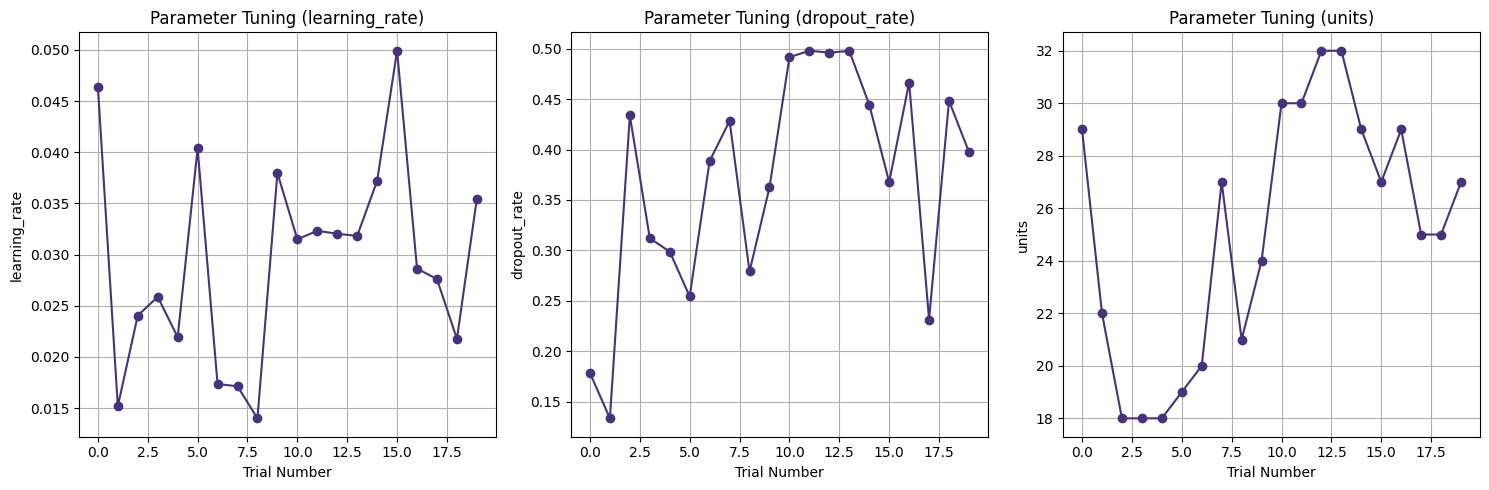

In [45]:

import matplotlib.pyplot as plt
import optuna

# Get the optimization history
trials = study.trials_dataframe()

# Plot the optimization history
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(trials['number'], trials['value'], marker='o')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Optuna Optimization History')
ax.grid(True)
plt.show()

# Plot the best parameters
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Updated parameter names to match Optuna's format
params_to_plot = ['params_learning_rate', 'params_dropout_rate', 'params_units']
param_labels = ['learning_rate', 'dropout_rate', 'units']  # Labels for the plots

for i, param in enumerate(params_to_plot):
    axs[i].plot(trials['number'], trials[param], marker='o')
    axs[i].set_xlabel('Trial Number')
    axs[i].set_ylabel(param_labels[i])  # Use the appropriate label
    axs[i].set_title(f'Parameter Tuning ({param_labels[i]})')  # Use the appropriate label
    axs[i].grid(True)

plt.tight_layout()
plt.show()

* Berdasarkan grafik ini, Optuna mampu meningkatkan akurasi validasi secara bertahap, namun beberapa parameter percobaan memberikan hasil kurang optimal sebelum menemukan kombinasi yang baik.
* Pada trial dengan akurasi terbaik (Trial 16), learning rate adalah 0.02863, yang berada di kisaran menengah dan menunjukkan stabilitas pada beberapa trial sebelumnya. Learning rate terlalu besar mungkin menyebabkan fluktuasi performa karena langkah pembaruan model terlalu besar.
*  trial dengan dropout rate yang lebih besar (0.45–0.5) menghasilkan akurasi lebih baik. dropout rate 0.466, menunjukkan bahwa dropout rate tinggi membantu regularisasi model. Dropout rate yang lebih tinggi efektif mengurangi overfitting dalam model, terutama di dataset yang diuji.
* Trial dengan units di kisaran 29–32 memberikan hasil yang lebih baik. Units terlalu kecil mungkin menyebabkan kapasitas model yang terbatas, sedangkan jumlah units yang lebih besar mendekati optimal.



## Kesimpulan
- Learning Rate: 0.02863445695392297
- Dropout Rate: 0.4663404852551372
- Units: 29
- Akurasi validasi tertinggi: 0.9137930870056152
Dicapai pada Trial 16.

* Proses optimisasi berhasil menemukan kombinasi hyperparameter yang memberikan hasil terbaik dengan akurasi validasi 0.913793, yang merupakan peningkatan signifikan dibandingkan Trial awal (0.865564).
* Trial 10, 11, 13, dan 16 memiliki akurasi di atas 0.90, menunjukkan bahwa learning rate di sekitar 0.028-0.032 dan dropout rate yang tinggi (di atas 0.44) memberikan hasil yang lebih baik.
